In [1]:
import numpy as np
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import tikzplotlib as tkz
import warnings
warnings.filterwarnings("ignore")

import os, sys

_, filename = os.path.split(os.getcwd())
if filename == 'notebooks':
    old_dir = os.getcwd()
    os.chdir('../')
    print('Moving Current Directory from ' + old_dir + ' to ' + os.getcwd())
else:
    print('Current Directory is ' + os.getcwd())

sys.path.append('./')  

from FRB.agents import UCB1Agent, FactoredUCBAgent, TMRobustUCBAgent #, FactoredUCBAgentMM
from FRB.env import FactoredEnv
from FRB.utils import get_pulled_expected, compute_max_expected, create_action_matrix, get_sigma_square_eq_max

Moving Current Directory from /home/simone/Projects/research/FRB/notebooks to /home/simone/Projects/research/FRB


In [2]:
class FactoredUCBAgentMM():
    """
    This class implements the FRB MM optimal algorithm in its anytime
    version for bounded variables
    """
    def __init__(self, k, d, time_horizon, sigma=0.5,
                 max_reward=1, exploration_alpha=4):
        self.k = k
        self.d = d
        self.T = time_horizon
        self.max_reward = max_reward
        self.sigma = sigma
        self.exploration_alpha = exploration_alpha
        self.num_actions = self.k ** self.d
        # Creation of the action matrix
        self.action_matrix = np.zeros(
            (self.num_actions, self.d), dtype=int
        )
        for i in range(self.d):
            vect = -1 * np.ones(self.k**(i+1))
            external_repeats = int(self.k**(self.d-(i+1)))
            internal_repeats = self.k**i
            for j in range(self.k):
                vect[j*internal_repeats:(j+1)*internal_repeats] = j
            vect_new = np.copy(vect).reshape(-1, 1)
            for _ in range(external_repeats-1):
                vect_new = np.vstack((vect_new, vect.reshape(-1, 1)))
            self.action_matrix[:, i] = vect_new.ravel()
        self.reset()

    def reset(self):
        self.t = 1
        self.last_pull = None
        self.n_min_pull = np.zeros(self.num_actions, dtype=int)
        self.n_pulls = np.zeros((self.d, self.k), dtype=int)
        self.observations = -1 * np.ones((self.d, self.k, self.T), dtype=int)
        self.virtual_pulls_sum = np.zeros(self.num_actions)

    def pull_arm(self):
        for i in range(self.num_actions):
            action_vector = self.action_matrix[i, :]
            new_min_pull = self.n_pulls[0, action_vector[0]]
            for j in range(1, self.d):
                new_min_pull = min(new_min_pull, self.n_pulls[j, action_vector[j]])
            if new_min_pull != self.n_min_pull[i]:
                self.n_min_pull[i] = new_min_pull
                aux = 1
                for j in range(self.d):
                    aux *= self.observations[j, self.last_pull[j], self.n_min_pull[i]-1]
                self.virtual_pulls_sum[i] += aux
        mean = self.virtual_pulls_sum / self.n_min_pull
        ucb = mean + self.sigma * np.sqrt(self.exploration_alpha * math.log(self.t) / self.n_min_pull)
        self.last_pull = self.action_matrix[int(np.argmax(ucb)), :]
        return self.last_pull

    def update(self, observations):
        self.t += 1
        for i in range(self.d):
            self.observations[i, self.last_pull[i], self.n_pulls[i, self.last_pull[i]]] = observations[i]
            self.n_pulls[i, self.last_pull[i]] = self.n_pulls[i, self.last_pull[i]] + 1

In [13]:
class FactoredUCBAgentHT():
    def __init__(self, k, d, time_horizon, sigma=0.5,
                 max_reward=1, exploration_alpha=4):
        self.k = k
        self.d = d
        self.T = time_horizon
        self.max_reward = max_reward
        self.sigma = np.sqrt((1 +sigma**2)**d - 1)
        self.exploration_alpha = exploration_alpha
        self.num_actions = self.k ** self.d
        # Creation of the action matrix
        self.action_matrix = np.zeros(
            (self.num_actions, self.d), dtype=int
        )
        self.mean_matrix = np.zeros(
            (self.num_actions, self.d), dtype=int
        )
        for i in range(self.d):
            vect = -1 * np.ones(self.k**(i+1))
            external_repeats = int(self.k**(self.d-(i+1)))
            internal_repeats = self.k**i
            for j in range(self.k):
                vect[j*internal_repeats:(j+1)*internal_repeats] = j
            vect_new = np.copy(vect).reshape(-1, 1)
            for _ in range(external_repeats-1):
                vect_new = np.vstack((vect_new, vect.reshape(-1, 1)))
            self.action_matrix[:, i] = vect_new.ravel()
        self.reset()

    def reset(self):
        self.t = 1
        self.last_pull = None
        self.n_min_pull = np.zeros(self.num_actions, dtype=int)
        self.n_pulls = np.zeros((self.d, self.k), dtype=int)
        self.observations = -1 * np.ones((self.d, self.k, self.T), dtype=int)
        self.virtual_pulls_sum = np.zeros(self.num_actions)

    def pull_arm(self):
        for i in range(self.num_actions):
            action_vector = self.action_matrix[i, :]
            new_min_pull = self.n_pulls[0, action_vector[0]]
            for j in range(1, self.d):
                new_min_pull = min(new_min_pull, self.n_pulls[j, action_vector[j]])
            if new_min_pull != self.n_min_pull[i]:
                self.n_min_pull[i] = new_min_pull

            if self.last_pull is not None and (action_vector == self.last_pull).any() and self.n_min_pull[i]>0:
                _observations = np.zeros((self.d, self.n_min_pull[i]-1))
                for h in range(self.d):
                    _observations[h, :] = self.observations[h,self.last_pull[h],:self.n_min_pull[i]-1]
                x = np.prod(_observations, axis = 0)
                self.virtual_pulls_sum[i] = self.trimmed_mean(x, self.sigma, 1/self.T, 1)
                
        mean = self.virtual_pulls_sum

        ucb = mean + self.sigma * np.sqrt(self.exploration_alpha * math.log(self.t**2) / self.n_min_pull)
        self.last_pull = self.action_matrix[int(np.argmax(ucb)), :]
        return self.last_pull

    def update(self, observations):
        self.t += 1
        for i in range(self.d):
            self.observations[i, self.last_pull[i], self.n_pulls[i, self.last_pull[i]]] = observations[i]
            self.n_pulls[i, self.last_pull[i]] = self.n_pulls[i, self.last_pull[i]] + 1

    def trimmed_mean(self, x, u, delta, epsilon):
        n = x.shape[0]
        mask = np.zeros(x.shape)
        _log = np.log(1/delta)
        
        t = np.arange(n)
        mask = np.abs(x) <= (u*t - _log)**(1/(1+epsilon))
        
        mask = np.array(mask, dtype='bool')

        mu = np.sum(x[mask]) / n
        return mu

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=2 d=1 $\sigma$=0.5
T=1000: $15.31 \ (2.57)$
T=2000: $22.41 \ (5.06)$
T=5000: $35.47 \ (10.81)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=2 d=1 $\sigma$=0.5
T=1000: $15.31 \ (2.57)$
T=2000: $22.41 \ (5.06)$
T=5000: $35.47 \ (10.81)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\ucbone run completed - k=2 d=1 $\sigma$=0.5
T=1000: $15.31 \ (2.57)$
T=2000: $22.41 \ (5.06)$
T=5000: $35.47 \ (10.81)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshortHT run completed - k=2 d=1 $\sigma$=0.5
T=1000: $74.43 \ (21.07)$
T=2000: $79.45 \ (21.54)$
T=5000: $81.17 \ (20.24)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=1 $\sigma$=0.5
T=1000: $32.12 \ (3.18)$
T=2000: $46.99 \ (5.29)$
T=5000: $65.08 \ (8.05)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=1 $\sigma$=0.5
T=1000: $32.12 \ (3.18)$
T=2000: $46.99 \ (5.29)$
T=5000: $65.08 \ (8.05)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=1 $\sigma$=0.5
T=1000: $32.12 \ (3.18)$
T=2000: $46.99 \ (5.29)$
T=5000: $65.08 \ (8.05)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshortHT run completed - k=3 d=1 $\sigma$=0.5
T=1000: $43.78 \ (18.79)$
T=2000: $44.06 \ (18.83)$
T=5000: $64.46 \ (14.74)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=2 d=2 $\sigma$=0.5
T=1000: $29.14 \ (3.12)$
T=2000: $37.63 \ (2.13)$
T=5000: $51.99 \ (6.97)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=2 d=2 $\sigma$=0.5
T=1000: $79.95 \ (23.12)$
T=2000: $145.71 \ (41.98)$
T=5000: $335.81 \ (104.39)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\ucbone run completed - k=2 d=2 $\sigma$=0.5
T=1000: $44.23 \ (1.95)$
T=2000: $66.41 \ (2.7)$
T=5000: $105.08 \ (5.41)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshortHT run completed - k=2 d=2 $\sigma$=0.5
T=1000: $97.5 \ (13.32)$
T=2000: $195.88 \ (26.24)$
T=5000: $484.22 \ (66.68)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=2 $\sigma$=0.5
T=1000: $41.7 \ (5.55)$
T=2000: $59.89 \ (7.39)$
T=5000: $90.17 \ (11.34)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=2 $\sigma$=0.5
T=1000: $48.99 \ (8.61)$
T=2000: $76.66 \ (22.05)$
T=5000: $147.98 \ (53.18)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=2 $\sigma$=0.5
T=1000: $72.5 \ (8.23)$
T=2000: $113.81 \ (20.13)$
T=5000: $198.2 \ (45.8)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshortHT run completed - k=3 d=2 $\sigma$=0.5
T=1000: $139.56 \ (18.63)$
T=2000: $280.41 \ (37.36)$
T=5000: $690.77 \ (86.43)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=2 d=3 $\sigma$=0.5
T=1000: $17.91 \ (1.74)$
T=2000: $26.25 \ (3.15)$
T=5000: $41.87 \ (3.48)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=2 d=3 $\sigma$=0.5
T=1000: $48.87 \ (10.99)$
T=2000: $89.25 \ (27.1)$
T=5000: $165.35 \ (72.95)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\ucbone run completed - k=2 d=3 $\sigma$=0.5
T=1000: $65.06 \ (12.42)$
T=2000: $117.3 \ (25.92)$
T=5000: $255.78 \ (68.31)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshortHT run completed - k=2 d=3 $\sigma$=0.5
T=1000: $71.93 \ (6.49)$
T=2000: $140.61 \ (13.48)$
T=5000: $346.21 \ (34.7)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=3 $\sigma$=0.5
T=1000: $40.85 \ (9.47)$
T=2000: $59.32 \ (11.15)$
T=5000: $100.04 \ (20.06)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=3 $\sigma$=0.5
T=1000: $94.76 \ (19.42)$
T=2000: $166.17 \ (38.47)$
T=5000: $422.23 \ (107.49)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=3 $\sigma$=0.5
T=1000: $110.18 \ (12.88)$
T=2000: $210.52 \ (24.94)$
T=5000: $488.68 \ (58.11)$


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

\JPAalgnameshortHT run completed - k=3 d=3 $\sigma$=0.5
T=1000: $133.69 \ (13.46)$
T=2000: $266.93 \ (25.66)$
T=5000: $656.76 \ (65.93)$


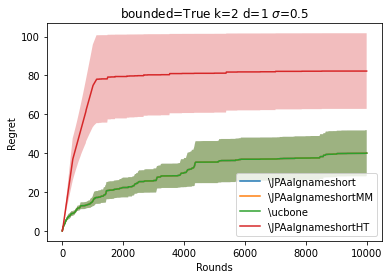

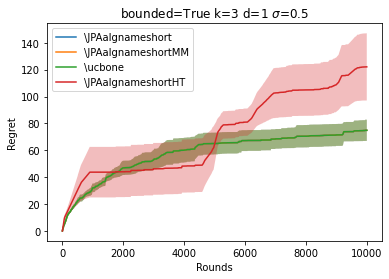

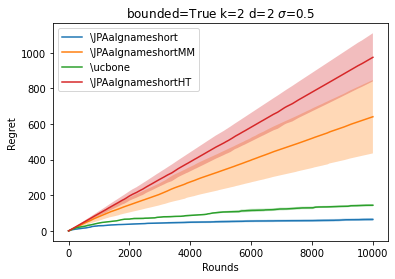

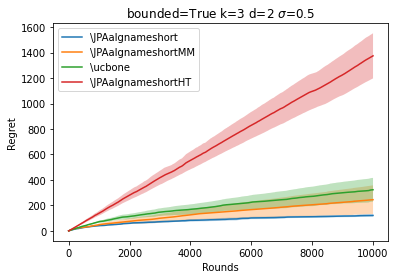

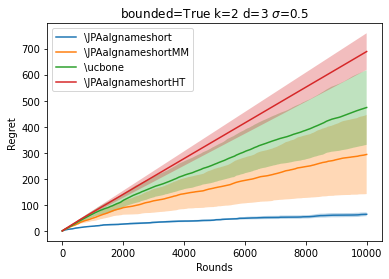

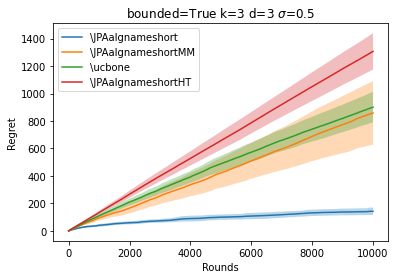

In [15]:
# BASIC SETTING FOR EXPERIMENTS
fucb = '\\JPAalgnameshort'
fucbMM = '\\JPAalgnameshortMM'
ucbone = '\\ucbone'
httem = '\\httem'
fucbHT = '\\JPAalgnameshortHT'
# algs = [fucb, fucbMM, fucbHT, ucbone, httem]
# T = 10000
# checkpoints = [1000, 5000, 10000]
# n_trials = 50
# seed = 0
# k_list = [3, 5]
# d_list = [1, 2, 3, 4]
# bounded_list = [True, False]   
# do_subsampling = True

# OVERRIDE FOR TESTING PURPOSE TO SPEED UP THE RUNS
T = 10000
checkpoints = [1000, 2000, 5000]
bounded_list = [True] 
algs = [fucb, fucbMM, ucbone, fucbHT]
n_trials = 4
k_list = [2, 3]
d_list = [1, 2, 3]
do_subsampling = False
    
result_table = {}

for bounded in bounded_list:

    result_table[bounded] = {}
    
    if bounded: 
        sigma = 0.5 # fixed for bernoulli
    else:
        sigma = 0.1
    
    for d in d_list:

        result_table[bounded][d] = {}

        for k in k_list:

            result_table[bounded][d][k] = {}

            arms_vect = k * np.ones(d, dtype=int)

            # F-UCB INIT
            agent_factored = FactoredUCBAgent(arms_vect, d, sigma)

            # F-UCB-MM INIT
            agent_factored_MM = FactoredUCBAgentMM(k, d, T)

            # F-UCB-HT INIT
            agent_factored_HT = FactoredUCBAgentHT(k, d, T)
            
            # UCB1 INIT
            agent_ucb = UCB1Agent(d*k, sigma)
            action_mx = create_action_matrix(d, k)

            # HT-TEM INIT
            agent_ht_tem = TMRobustUCBAgent(d*k, 1, 1)
            
            mean_cum_expected_regret = {}
            std_cum_expected_regret = {}
            
            for alg in algs:

                result_table[bounded][d][k][alg] = {}

                env = FactoredEnv(arms_vect, d, sigma=sigma, bounded=bounded)

                inst_expected_regret = np.zeros((n_trials, T))
                
                # for trial_i in range(n_trials):
                for trial_i in tqdm(range(n_trials)):
                
                    vals_expected = env.get_expected()
                    max_expected = compute_max_expected(vals_expected)

                    for t in tqdm(range(T)):

                        if alg == ucbone:
                            action = action_mx[agent_ucb.pull_arm(), :]
                            agent_ucb.update(np.prod(env.step(action)))
                        elif alg == fucb:
                            action = agent_factored.pull_arm()
                            agent_factored.update(env.step(action))
                        elif alg == fucbMM:
                            action = agent_factored_MM.pull_arm()
                            agent_factored_MM.update(env.step(action))
                        elif alg == httem:
                            action = action_mx[agent_ht_tem.pull_arm(), :]
                            agent_ht_tem.update(np.prod(env.step(action)))
                        elif alg == fucbHT:
                            action = agent_factored_HT.pull_arm()
                            agent_factored_HT.update(env.step(action))
                        else:
                            raise ValueError('Error in selecting algorithm')

                        inst_expected_regret[trial_i, t] = max_expected - get_pulled_expected(
                            vals_expected, action)
                    
                    # I reset all the agents, becuase i do not know which one 
                    # i am using for the sake of simplicity
                    agent_ucb.reset()
                    agent_factored.reset()
                    agent_factored_MM.reset()
                    agent_factored_HT.reset()
                    agent_ht_tem.reset()
                    
                    if trial_i < n_trials - 1:
                        env.reset()
                
                # maybe replace with cumsum with correct axis
                cum_expected_regret = np.zeros(inst_expected_regret.shape)
                cum_expected_regret[:, 0] = inst_expected_regret[:, 0]
                for i in range(1, T):
                    cum_expected_regret[:, i] = inst_expected_regret[:, i] + cum_expected_regret[:, i-1]

                mean_cum_expected_regret[alg] = np.mean(cum_expected_regret, axis=0)
                std_cum_expected_regret[alg] = np.std(cum_expected_regret, axis=0) / np.sqrt(n_trials)

                print('{} run completed - k={} d={} $\sigma$={}'.format(alg, k, d, sigma))
                for i in checkpoints:
                    result_table[bounded][d][k][alg][i] = '${} \ ({})$   '.format(
                        round(mean_cum_expected_regret[alg][i-1], 2), 
                        round(std_cum_expected_regret[alg][i-1], 2)
                    )
                    print('T={}: ${} \ ({})$'.format(i, round(mean_cum_expected_regret[alg][i-1], 2), 
                                                  round(std_cum_expected_regret[alg][i-1], 2)))

            plt.figure()
            if do_subsampling:
                subsample = 50
                assert T % subsample == 0
                x_plt = np.linspace(0, T-1, int(T/subsample), dtype=int)
            else:
                x_plt = np.linspace(0, T-1, T, dtype=int)
            for alg in algs:
                plt.plot(x_plt, mean_cum_expected_regret[alg][x_plt], 
                         label=alg)
                plt.fill_between(x_plt, 
                                 mean_cum_expected_regret[alg][x_plt] - std_cum_expected_regret[alg][x_plt], 
                                 mean_cum_expected_regret[alg][x_plt] + std_cum_expected_regret[alg][x_plt], 
                                 alpha=0.3)
            plt.legend()
            plt.xlabel('Rounds')
            plt.ylabel('Regret')
            plt.title('bounded={} k={} d={} $\sigma$={}'.format(bounded, k, d, sigma))
            if bounded:
                save_str = 'results/bounded_k{}_d{}'.format(k, d)
            else:
                save_str = 'results/subgauss_k{}_d{}'.format(k, d)
            plt.savefig(save_str + '.png')
            tkz.save(save_str + '.tex')

In [ ]:
print('d= \t k= \t T=\t\t', end='')
[print(alg, end='\t\t\t') for alg in algs]
print('')

for d in d_list:
    for k in k_list:
        for T_val in checkpoints:
            print('${}$ & \t ${}$ & \t ${}$ \t\t'.format(d, k, T_val), end='')
            for bounded in bounded_list:
                for alg in algs:
                    print('&', result_table[bounded][d][k][alg][T_val], end='\t')
            if T_val == checkpoints[-1]:
                print('\\\\\n\\cmidrule{2-10}')
            else:
                print('\\\\\n\\cmidrule{3-10}')
    print('\cmidrule{1-10}')